In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### LSTMs for Human Activity Recognition

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:

1. WALKING,
2. WALKING_UPSTAIRS,
3. WALKING_DOWNSTAIRS,
4. SITTING,
5. STANDING,
6. LAYING.

Compared to the classical Machine Learning approaches, Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering at all. Remember, we needed a lot of feature engineering to be done in for our Machine Learning models to achieve the accuracy it has! (96% max). In RNN-LSTMs, raw data can be fed directly into the neural network which acts like a black box, without ay feature engineering whatsoever! Other research in this topic of activity recognition uses a huge amount of feature engineering, which are signal processing approaches combined with classical Machine Learning/Data Science techniques. The approach here is rather very simple in terms of how much was the data preprocessed. Almost none. All we need to take care is how we design our Deep Learning models.

We will TensorFlow and Keras Libraries to demonstrate the usage of an LSTM, a type of Artificial Neural Network that can process sequential data / time series data.

### How the data was recorded?

Please watch this Youtube video link I have attached below to see how the data was recorded.

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>

### Details about the input data

I will be using a special type of Recurrent Neural Network called LSTM on the dataset to learn (as a cellphone attached on the waist) to recognise what type of activity the user is doing. Few very important points about the dataset are as follows:

1. These sensor signals are preprocessed by applying noise filters and then sampled in fixed-width windows(sliding windows) of 2.56 seconds each with 50% overlap. ie., each window has 128 readings. 
2. From Each window, a feature vector was obtianed by calculating variables from the time and frequency domain. In our dataset, each datapoint represents a window with different readings 
3. The accelertion signal was saperated into Body and Gravity acceleration signals(___tBodyAcc-XYZ___ and ___tGravityAcc-XYZ___) using some low pass filter with corner frequecy of 0.3Hz.

4. After that, the body linear acceleration and angular velocity were derived in time to obtian _jerk signals_ (___tBodyAccJerk-XYZ___ and ___tBodyGyroJerk-XYZ___). 

5. The magnitude of these 3-dimensional signals were calculated using the Euclidian norm. This magnitudes are represented as features with names like _tBodyAccMag_, _tGravityAccMag_, _tBodyAccJerkMag_, _tBodyGyroMag_ and _tBodyGyroJerkMag_.

6. Finally, We've got frequency domain signals from some of the available signals by applying a FFT (Fast Fourier Transform). These signals obtained were labeled with ___prefix 'f'___ just like original signals with ___prefix 't'___. These signals are labeled as ___fBodyAcc-XYZ___, ___fBodyGyroMag___ etc.,.

7. These are the signals that we got so far.
	+ tBodyAcc-XYZ
	+ tGravityAcc-XYZ
	+ tBodyAccJerk-XYZ
	+ tBodyGyro-XYZ
	+ tBodyGyroJerk-XYZ
	+ tBodyAccMag
	+ tGravityAccMag
	+ tBodyAccJerkMag
	+ tBodyGyroMag
	+ tBodyGyroJerkMag
	+ fBodyAcc-XYZ
	+ fBodyAccJerk-XYZ
	+ fBodyGyro-XYZ
	+ fBodyAccMag
	+ fBodyAccJerkMag
	+ fBodyGyroMag
	+ fBodyGyroJerkMag


###  Y_Labels(Encoded)
+ In the dataset, Y_labels are represented as numbers from 1 to 6 as their identifiers.

	- WALKING as __1__
	- WALKING_UPSTAIRS as __2__
	- WALKING_DOWNSTAIRS as __3__
	- SITTING as __4__
	- STANDING as __5__
	- LAYING as __6__

### What is an RNN?

For details about what RNNs are please visit this wonderful article written by Andrej Karpathy titled "The Unreasonable Effectiveness of Recurrent Neural Networks". As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

> <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/" ><img src="http://karpathy.github.io/assets/rnn/diags.jpeg" /></a>
> http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### What is an LSTM?

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. I recommend [this article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) for you to learn more on LSTMs.


### Take the class labels into a Dictionary

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

### Utility functions to obtain the train and test data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the signal data
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).as_matrix()) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    
    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

### Utility functions to assess model performance

In [8]:
#Train vs Test loss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

#This function is used to plot/update the train and test loss after each epoch.
def plt_dynamic_loss(x, vy, ty, ax, colors=['b']):
    #plt.figure(figsize=(7,7))
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

#Utility function to plot the confusion matrices
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm_df, classes, normalize, title):
    if normalize:
        cm = cm_df.values
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        plt.figure(figsize = (7,7))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=90)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
    
    else:
        import seaborn as sn
        plt.figure(figsize = (6,5))
        ax = sn.heatmap(cm_df, annot=True, fmt='d', cmap=plt.cm.Blues)   #fmt='d' for decimal integer.
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(title)

#Utility function to design the confusion matrix DF
def get_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    cm_df =  pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return cm_df

### Start building a Deep Learning model using TensorFlow

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, y_train, y_test = load_data()

In [15]:
X_train.shape #X_train contains 7352 entries. Each data point has 9 distinct features. Each feature is represented by a 128 dimensional vector

(7352, 128, 9)

In [16]:
#Vector representation of a single feature
X_train[0]

array([[ 1.808515e-04,  1.076681e-02,  5.556068e-02, ...,  1.012817e+00,
        -1.232167e-01,  1.029341e-01],
       [ 1.013856e-02,  6.579480e-03,  5.512483e-02, ...,  1.022833e+00,
        -1.268756e-01,  1.056872e-01],
       [ 9.275574e-03,  8.928878e-03,  4.840473e-02, ...,  1.022028e+00,
        -1.240037e-01,  1.021025e-01],
       ...,
       [-1.147484e-03,  1.714439e-04,  2.647864e-03, ...,  1.018445e+00,
        -1.240696e-01,  1.003852e-01],
       [-2.222655e-04,  1.574181e-03,  2.381057e-03, ...,  1.019372e+00,
        -1.227451e-01,  9.987355e-02],
       [ 1.575500e-03,  3.070189e-03, -2.269757e-03, ...,  1.021171e+00,
        -1.213260e-01,  9.498741e-02]])

In [17]:
#Number of features for one datapoint
X_train[0][0]

array([ 1.808515e-04,  1.076681e-02,  5.556068e-02,  3.019122e-02,
        6.601362e-02,  2.285864e-02,  1.012817e+00, -1.232167e-01,
        1.029341e-01])

In [18]:
#Documentation
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


### 1. Defining the Architecture of LSTM. This is our baseline model with 32 LSTM Units.

In [20]:
import warnings
warnings.filterwarnings("ignore")

# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32 #32 LSTM Units

# Initiliazing the sequential model1
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


### Compiling and Training the model

In [21]:
# Compiling the model
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [23]:
# Training the model
model1.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 55s 7ms/step - loss: 1.3914 - acc: 0.3570 - val_loss: 1.3154 - val_acc: 0.3505
Epoch 2/30
7352/7352 [==============================] - 54s 7ms/step - loss: 1.1624 - acc: 0.4656 - val_loss: 1.2046 - val_acc: 0.4506
Epoch 3/30
7352/7352 [==============================] - 54s 7ms/step - loss: 1.0288 - acc: 0.5325 - val_loss: 0.9904 - val_acc: 0.5063
Epoch 4/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.8890 - acc: 0.6119 - val_loss: 0.8544 - val_acc: 0.5877
Epoch 5/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.7884 - acc: 0.6469 - val_loss: 0.8368 - val_acc: 0.6064
Epoch 6/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.7299 - acc: 0.6673 - val_loss: 0.8442 - val_acc: 0.6206
Epoch 7/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.7060 - acc: 0.6719 - val_loss: 0.7821 - val_acc: 0.6413
Epoch 8

### Score evaluation

In [24]:
results = []
#Plot the train and test loss vs number of epochs
score_test = model1.evaluate(X_test, y_test, verbose=1) 
score_train = model1.evaluate(X_train, y_train, verbose=1) 

print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])

print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])

scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

7352/7352 [==============================] - 5s 742us/step

Validation accuracy: 0.8900576857821514
Train Accuracy: 0.9504896626768227

Validation Loss: 0.3715693044099767
Train Loss: 0.12927464863579438


- With a simple 2 layer architecture we got 89% accuracy and a loss of 0.12. Not bad by any means, considering the fact that we did not do any feature engineering whatsoever!
- Looking at the train and test loss, we can say there might be a small overfitting.
- We can further improve the performace with Hyperparameter tuning. For now let's plot the Train vs Cross Validation Loss, and also the Confusion Matrix to get an idea about individual class accuracies, precisions, recalls.

### Plot the Train and Validation loss for all epochs to get an idea if our model is overfitted/underfitted.

In [25]:
history1=model1.history #Get the history object which stores all the histories of test/train/validation loss/accuracy

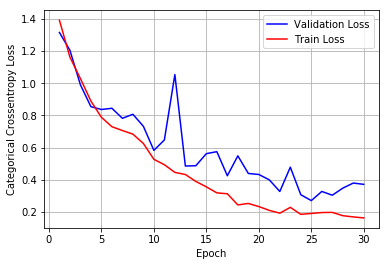

In [26]:
#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the model
val_loss = history1.history['val_loss'] #Validation Loss
loss = history1.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax)

### Plot Confusion Matrices to evaluate the model.

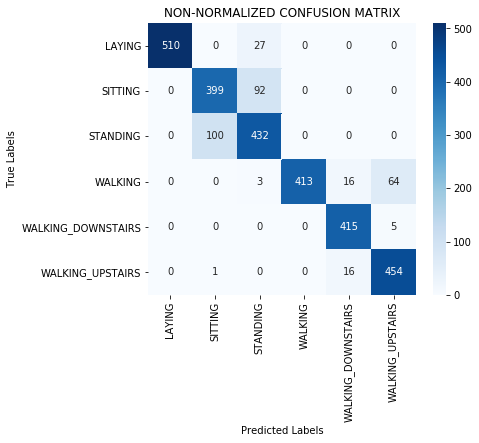

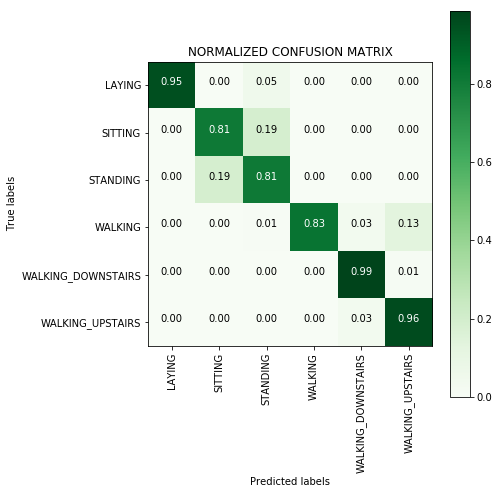

In [28]:
#Get the confusion matrix
y_pred=model1.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df

#Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX")

#Plot a Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX")

## Manual Hyperparameter tuning Section. 

### 2. Model with 1 LSTM Layer having 16 LSTM units

In [ ]:
import warnings
warnings.filterwarnings("ignore")

'''Initializing parameters'''
epochs = 30
batch_size = 16
n_hidden = 16 #16 LSTM Units

'''Define and train the model'''
model2 = Sequential() # Initiliazing the sequential model2
model2.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) # Configuring the parameters
model2.add(Dropout(0.5)) # Adding a dropout layer
model2.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiling the model
model2.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model

'''Get the history object which stores all the histories of test/train/validation loss/accuracy'''
history2=model2.history 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 47s 6ms/step - loss: 1.4984 - acc: 0.3754 - val_loss: 1.2799 - val_acc: 0.4639
Epoch 2/30
7352/7352 [==============================] - 46s 6ms/step - loss: 1.1144 - acc: 0.5024 - val_loss: 1.0527 - val_acc: 0.5290
Epoch 3/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.9615 - 

In [ ]:
'''Get the train and test loss'''
score_test = model2.evaluate(X_test, y_test, verbose=1) 
score_train = model2.evaluate(X_train, y_train, verbose=1) 
print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])
print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])
scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

In [ ]:
'''Plot train vs test loss'''
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history2.history['val_loss'] #Validation Loss
loss = history2.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax) #Display the model

In [ ]:
'''Plot the confusion matrix'''
y_pred=model2.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX") #Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX") #Plot a Normalized confusion matrix

### 3. Model with 1 LSTM Layer having 64 LSTM units + Large Dropout (0.6) + BatchNormalization (to avoid Overfitting + Exploding Gradient Problem)

In [61]:
import warnings
warnings.filterwarnings("ignore")
from keras.layers.normalization import BatchNormalization

'''Initializing parameters'''
epochs = 30
batch_size = 16
n_hidden = 64 #64 LSTM Units

'''Define and train the model'''
model3 = Sequential() # Initiliazing the sequential model3
model3.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) # Configuring the parameters
model.add(BatchNormalization()) # Adding a batch normalization layer
model3.add(Dropout(0.6)) # Adding a dropout layer
model3.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiling the model
model3.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model

'''Get the history object which stores all the histories of test/train/validation loss/accuracy'''
history3=model3.history 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 57s 8ms/step - loss: 1.2711 - acc: 0.4558 - val_loss: 1.2824 - val_acc: 0.4418
Epoch 2/30
7352/7352 [==============================] - 55s 7ms/step - loss: 1.0819 - acc: 0.5355 - val_loss: 1.0182 - val_acc: 0.5887
Epoch 3/30
7352/7352 [==============================] - 55s 7ms/step - loss: 0.8359 

In [62]:
'''Get the train and test loss'''
score_test = model3.evaluate(X_test, y_test, verbose=1) 
score_train = model3.evaluate(X_train, y_train, verbose=1) 
print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])
print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])
scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

7352/7352 [==============================] - 8s 1ms/step

Validation accuracy: 0.168306752629793
Train Accuracy: 0.16675734494015235

Validation Loss: nan
Train Loss: nan


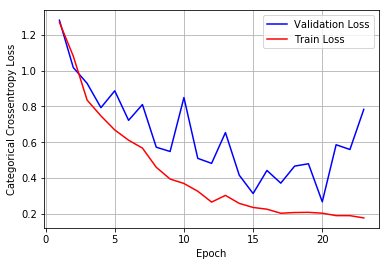

In [63]:
'''Plot train vs test loss'''
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history3.history['val_loss'] #Validation Loss
loss = history3.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax) #Display the model

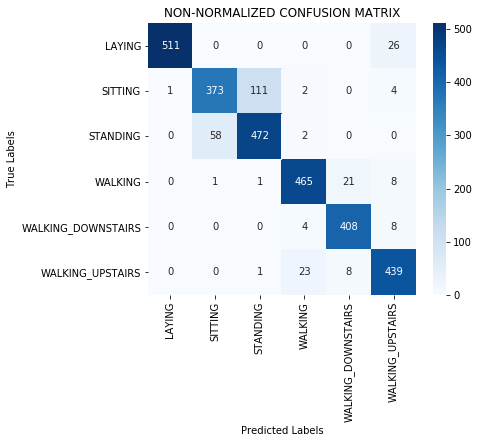

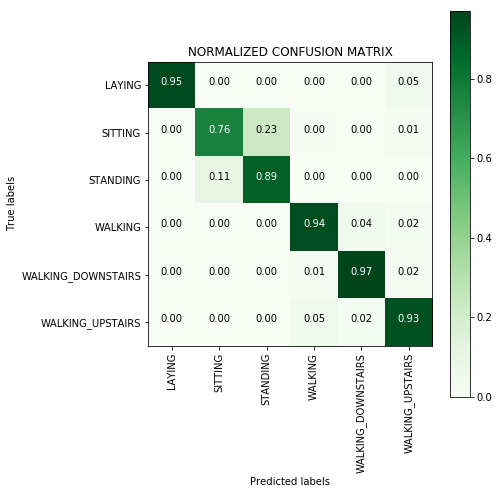

In [64]:
'''Plot the confusion matrix'''
y_pred=model.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX") #Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX") #Plot a Normalized confusion matrix

### 4. Model with 1 LSTM Layer having 128 LSTM units + Batch Normalization + Even Larger Dropout (0.7)

In [65]:
import warnings
warnings.filterwarnings("ignore")

'''Initializing parameters'''
epochs = 30
batch_size = 16
n_hidden = 128 #128 LSTM Units

'''Define and train the model'''
model4 = Sequential() # Initiliazing the sequential model4
model4.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) # Configuring the parameters
model.add(BatchNormalization())
model4.add(Dropout(0.8)) # Adding a dropout layer
model4.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model4.summary()
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiling the model
model4.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model

'''Get the history object which stores all the histories of test/train/validation loss/accuracy'''
history4=model4.history 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 97s 13ms/step - loss: 1.2382 - acc: 0.4529 - val_loss: 1.0611 - val_acc: 0.5609
Epoch 2/30
7352/7352 [==============================] - 95s 13ms/step - loss: 1.0936 - acc: 0.5272 - val_loss: 0.9143 - val_acc: 0.5860
Epoch 3/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.98

In [66]:
'''Get the train and test loss'''
score_test = model4.evaluate(X_test, y_test, verbose=1) 
score_train = model4.evaluate(X_train, y_train, verbose=1) 
print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])
print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])
scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

7352/7352 [==============================] - 16s 2ms/step

Validation accuracy: 0.168306752629793
Train Accuracy: 0.16675734494015235

Validation Loss: nan
Train Loss: nan


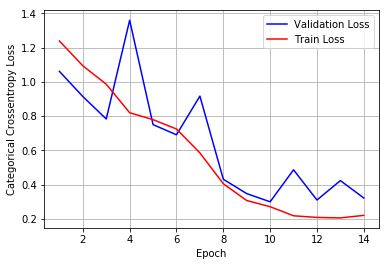

In [67]:
'''Plot train vs test loss'''
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history4.history['val_loss'] #Validation Loss
loss = history4.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax) #Display the model

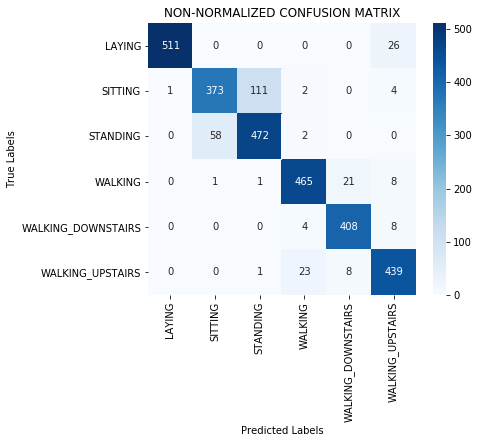

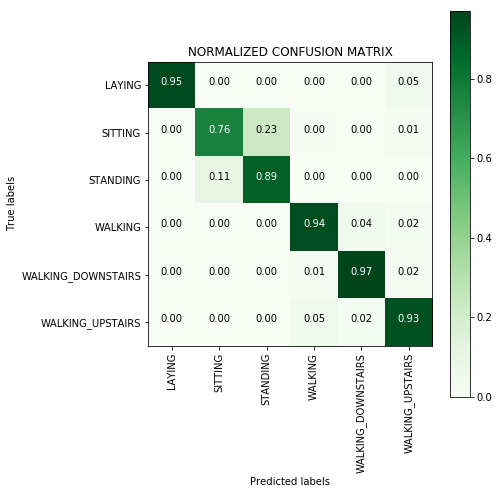

In [68]:
'''Plot the confusion matrix'''
y_pred=model.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX") #Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX") #Plot a Normalized confusion matrix

### 5. Model with 2 LSTM Layers having 32 LSTM units + Dropout (0.5)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

'''Initializing parameters'''
epochs = 30
batch_size = 16
n_hidden = 32 #32 LSTM Units

'''Define and train the model'''
model5 = Sequential() # Initiliazing the sequential model5
model5.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim))) # First LSTM Layer
model5.add(Dropout(0.5)) # Adding a dropout layer
model5.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) # Second LSTM Layer
model5.add(Dropout(0.5)) # Adding a dropout layer
model5.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model5.summary()
model5.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiling the model
model5.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model

'''Get the history object which stores all the histories of test/train/validation loss/accuracy'''
history5=model5.history 

In [ ]:
'''Get the train and test loss'''
score_test = model5.evaluate(X_test, y_test, verbose=1) 
score_train = model5.evaluate(X_train, y_train, verbose=1) 
print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])
print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])
scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

In [ ]:
'''Plot train vs test loss'''
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history5.history['val_loss'] #Validation Loss
loss = history5.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax) #Display the model

In [ ]:
'''Plot the confusion matrix'''
y_pred=model.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX") #Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX") #Plot a Normalized confusion matrix

### 6. Model with 2 LSTM Layers having 64 LSTM units + Larger Dropouts (0.7)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

'''Initializing parameters'''
epochs = 30
batch_size = 16
n_hidden = 64 #64 LSTM Units

'''Define and train the model'''
model6 = Sequential() # Initiliazing the sequential model6
model6.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim))) # First LSTM Layer
model6.add(Dropout(0.5)) # Adding a dropout layer
model6.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) # Second LSTM Layer
model6.add(Dropout(0.5)) # Adding a dropout layer
model6.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model6.summary()
model6.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiling the model
model6.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model

'''Get the history object which stores all the histories of test/train/validation loss/accuracy'''
history6=model6.history 

In [ ]:
'''Get the train and test loss'''
score_test = model6.evaluate(X_test, y_test, verbose=1) 
score_train = model6.evaluate(X_train, y_train, verbose=1) 
print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])
print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])
scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

In [ ]:
'''Plot train vs test loss'''
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history6.history['val_loss'] #Validation Loss
loss = history6.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax) #Display the model

In [ ]:
'''Plot the confusion matrix'''
y_pred=model.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX") #Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX") #Plot a Normalized confusion matrix

### 7. Model with 2 LSTM Layers having 64 LSTM units + Larger Dropouts (0.7) + Batch Normalization

In [ ]:
import warnings
warnings.filterwarnings("ignore")

'''Initializing parameters'''
epochs = 30
batch_size = 16
n_hidden = 64 #64 LSTM Units

'''Define and train the model'''
model7 = Sequential() # Initiliazing the sequential model7
model7.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim))) # First LSTM Layer
model7.add(Dropout(0.5)) # Adding a dropout layer
model7.add(LSTM(n_hidden, input_shape=(timesteps, input_dim))) # Second LSTM Layer
model7.add(Dropout(0.5)) # Adding a dropout layer
model7.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation
model7.summary()
model7.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) # Compiling the model
model7.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model

'''Get the history object which stores all the histories of test/train/validation loss/accuracy'''
history7=model7.history 

In [ ]:
'''Get the train and test loss'''
score_test = model7.evaluate(X_test, y_test, verbose=1) 
score_train = model7.evaluate(X_train, y_train, verbose=1) 
print('\nValidation accuracy:', score_test[1])
print('Train Accuracy:', score_train[1])
print('\nValidation Loss:', score_test[0]) 
print('Train Loss:', score_train[0])
scores = [score_test[1], score_train[1], score_test[0], score_train[0]]
results.append(scores)

In [ ]:
'''Plot train vs test loss'''
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1)) #List of epoch numbers
val_loss = history7.history['val_loss'] #Validation Loss
loss = history7.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax) #Display the model

In [ ]:
'''Plot the confusion matrix'''
y_pred=model.predict(X_test)
cm_df=get_confusion_matrix(y_test, y_pred) #Prepare the confusion matrix by using get_confusion_matrix() defined above.
classes=list(cm_df.index) #Class names = Index Names or Column Names in cm_df
plot_confusion_matrix(cm_df, classes, normalize=False, title="NON-NORMALIZED CONFUSION MATRIX") #Plot a Non-Normalized confusion matrix
plot_confusion_matrix(cm_df, classes, normalize=True, title="NORMALIZED CONFUSION MATRIX") #Plot a Normalized confusion matrix

## Hyperparameter tuning using Hyperas. 

In [87]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

### Hyperparameter tuning without data normalization

In [109]:
X_train, X_test, y_train, y_test = load_data()

In [110]:
#Defining a data function which is used by Hyperas. This data function directly loads train and test data from the source 
def data_func():
    #X_train, X_test, y_train, y_test = load_data()
    return X_train, y_train, X_test, y_test

In [111]:
#Defining a model function 

def model_func(X_train, X_test, y_train, y_test):
    
    model = Sequential()
    
    if conditional({{choice(['one', 'two'])}}) == 'two':
        model.add(LSTM(units={{choice([32,48,64,80])}}, activation={{choice(['tanh','relu','sigmoid','softplus'])}},
                       kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)),
                       input_shape=(timesteps, input_dim),return_sequences=True)
        model.add(Dropout({{uniform(0, 1)}})) # Adding a dropout layer
        model.add(BatchNormalization()) # Adding batch normalization
        #Adding a second LSTM Layer
        model.add(LSTM(units={{choice([32,48,64,80])}}, activation={{choice(['tanh','relu','sigmoid','softplus'])}},
                       kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)),
                       input_shape=(timesteps, input_dim))
        
    else:
        model.add(LSTM(units={{choice([32,48,64,80])}}, activation={{choice(['tanh','relu','sigmoid','softplus'])}},
                       kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)),
                       input_shape=(timesteps, input_dim))
 
    model.add(Dropout({{uniform(0, 1)}})) # Adding a dropout layer
    model.add(BatchNormalization()) # Adding batch normalization 
    model.add(Dense(n_classes, activation='sigmoid')) # Adding a dense output layer with sigmoid activation    
    
    # Tune the optimzers
    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
    
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optimizer = adam
    elif choiceval == 'rmsprop':
        optimizer = rmsprop
    else:
        optimizer = sgd
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # Compiling the model
    model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test), epochs=epochs) # Training the model
    #history=model.history 
    
    score, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [112]:
from datetime import datetime as dt
st = dt.now()
X_train, y_train, X_test, y_test = data_func()
best_run, best_model = optim.minimize(model=model_func,
                                      data=data_func,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='HAR_LSTM',
                                      verbose=2)

print("The best model is: ",best_model)
print("The best score is: ",best_run)
print("\nTime taken to perform Hyperparameter tuning:",dt.now()-st)

>>> Imports:
#coding=utf-8

try:
    from IPython.core.display import display, HTML
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import warnings
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import itertools
except:
    pass

try:
    import seaborn as sn
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    import warnings
except:
    pass

try:
    import warnings
except:
    pass

try:
    import warnings
except:
    pass

try:
    import warnings
except:
    pass

try:
    import warn

NameError: name 'conditional' is not defined

In [77]:
import pickle
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [ ]:
def model(X_train, Y_train, X_val, Y_val):
    
    model = Sequential()
    model.add(Dense({{choice([128, 256, 512, 1024])}}, input_shape=(784,)))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    if conditional({{choice(['two', 'three'])}}) == 'three':
        model.add(Dense({{choice([128, 256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        

    model.add(Dense(10))
    model.add(Activation('softmax'))

    adam = keras.optimizers.Adam(lr={{choice([10**-3, 10**-2, 10**-1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10**-3, 10**-2, 10**-1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10**-3, 10**-2, 10**-1])}})
   
    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)

    model.fit(X_train, Y_train,
              batch_size={{choice([128,256,512])}},
              nb_epoch=20,
              verbose=2,
              validation_data=(X_val, Y_val))
    score, acc = model.evaluate(X_val, Y_val, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}